In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
from scipy import ndimage

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors

In [4]:
from caterpillar import catalog

In [2]:
pdr2_zp = 31.4

In [6]:
anom_file = '/Users/song/Downloads/anomaly/anomaly_catalog_hsc_full.fits'
anom_cat = Table.read(anom_file)

print(anom_cat.colnames)

['idx', 'ra', 'dec', 'discriminator_score_normalized', 'generator_score_normalized', 'combined_score_normalized', 'object_id', 'parent_id', 'tract', 'patch', 'a_g', 'a_r', 'a_i', 'a_z', 'a_y', 'g_cmodel_exp_flux', 'g_cmodel_exp_fluxsigma', 'r_cmodel_exp_flux', 'r_cmodel_exp_fluxsigma', 'i_cmodel_exp_flux', 'i_cmodel_exp_fluxsigma', 'z_cmodel_exp_flux', 'z_cmodel_exp_fluxsigma', 'y_cmodel_exp_flux', 'y_cmodel_exp_fluxsigma', 'g_cmodel_flux', 'g_cmodel_fluxsigma', 'r_cmodel_flux', 'r_cmodel_fluxsigma', 'i_cmodel_flux', 'i_cmodel_fluxsigma', 'z_cmodel_flux', 'z_cmodel_fluxsigma', 'y_cmodel_flux', 'y_cmodel_fluxsigma', 'g_cmodel_flag', 'r_cmodel_flag', 'i_cmodel_flag', 'z_cmodel_flag', 'y_cmodel_flag', 'g_psf_flux', 'g_psf_fluxsigma', 'r_psf_flux', 'r_psf_fluxsigma', 'i_psf_flux', 'i_psf_fluxsigma', 'z_psf_flux', 'z_psf_fluxsigma', 'y_psf_flux', 'y_psf_fluxsigma', 'g_psf_flag', 'r_psf_flag', 'i_psf_flag', 'z_psf_flag', 'y_psf_flag', 'g_convolvedflux_2_15_flux', 'g_convolvedflux_2_15_fluxsi

### Filter through the bright star mask

In [10]:
mask_dir = '/Users/song/astro1/hsc/bright_star_new/'

anom_bsm = catalog.filter_through_bright_star_mask(anom_file, mask_dir)

In [11]:
anom_bsm = catalog.moments_to_shape(anom_bsm, shape_type='i_sdss_shape', update=True)
anom_bsm = catalog.moments_to_shape(anom_bsm, shape_type='i_cmodel_exp_ellipse', update=True)
anom_bsm = catalog.moments_to_shape(anom_bsm, shape_type='i_cmodel_ellipse', update=True)
anom_bsm = catalog.moments_to_shape(anom_bsm, shape_type='r_cmodel_exp_ellipse', update=True)
anom_bsm = catalog.moments_to_shape(anom_bsm, shape_type='r_cmodel_ellipse', update=True)

In [17]:
len(anom_bsm)

824834

#### Objects within the bright star mask

In [12]:
anom_msk = catalog.filter_through_bright_star_mask(
    anom_file, mask_dir, filter_type='inside', output_suffix='masked')

In [13]:
anom_msk = catalog.moments_to_shape(anom_msk, shape_type='i_sdss_shape', update=True)
anom_msk = catalog.moments_to_shape(anom_msk, shape_type='i_cmodel_exp_ellipse', update=True)
anom_msk = catalog.moments_to_shape(anom_msk, shape_type='i_cmodel_ellipse', update=True)
anom_msk = catalog.moments_to_shape(anom_msk, shape_type='r_cmodel_exp_ellipse', update=True)
anom_msk = catalog.moments_to_shape(anom_msk, shape_type='r_cmodel_ellipse', update=True)

In [18]:
len(anom_msk)

80341

In [24]:
anom_bsm.write('/Users/song/Downloads/anomaly/anomaly_catalog_hsc_full_bsm.fits', overwrite=True)
anom_msk.write('/Users/song/Downloads/anomaly/anomaly_catalog_hsc_full_msk.fits', overwrite=True)

#### Distributions of scores

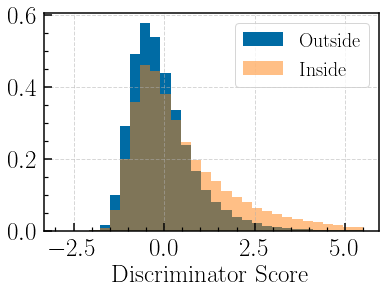

In [41]:
_ = plt.hist(anom_bsm['discriminator_score_normalized'], bins=30, 
             density=True, label=r'$\rm Outside$', range=(-2.9, 5.5))
_ = plt.hist(anom_msk['discriminator_score_normalized'], bins=30, alpha=0.5, 
             density=True, label=r'$\rm Inside$', range=(-2.9, 5.5))

plt.xlabel(r'$\rm Discriminator\ Score$', fontsize=25)
plt.legend(fontsize=20)

In [55]:
print(np.nanmean(anom_bsm['discriminator_score_normalized']), np.nanmedian(anom_bsm['discriminator_score_normalized']), np.nanstd(anom_bsm['discriminator_score_normalized']))
print(np.nanmean(anom_msk['discriminator_score_normalized']), np.nanmedian(anom_msk['discriminator_score_normalized']), np.nanstd(anom_msk['discriminator_score_normalized']))

-0.05095561630824006 -0.22421909123659134 0.9115174866404026
0.5537851732041797 0.10782042145729065 1.575268671903773


In [56]:
-0.051 + 3 * 0.911

2.682

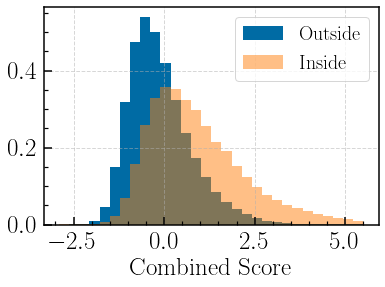

In [42]:
_ = plt.hist(anom_bsm['combined_score_normalized'], bins=30, 
             density=True, label=r'$\rm Outside$', range=(-2.9, 5.5))
_ = plt.hist(anom_msk['combined_score_normalized'], bins=30, alpha=0.5, 
             density=True, label=r'$\rm Inside$', range=(-2.9, 5.5))

plt.xlabel(r'$\rm Combined\ Score$', fontsize=25)
plt.legend(fontsize=20)

#### Isolate the truly extended objects

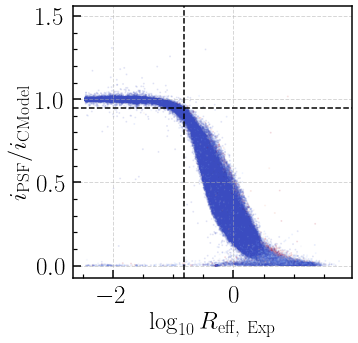

In [149]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(anom_bsm['i_cmodel_exp_ellipse_r']), 
            anom_bsm['i_psf_flux'] / anom_bsm['i_cmodel_flux'], 
            c=anom_bsm['combined_score_normalized'], s=1, alpha=0.1, cmap='coolwarm',
            vmin=1, vmax=5)

plt.axvline(np.log10(0.15), c='k', linestyle='--')
plt.axhline(0.95, c='k', linestyle='--')

_ = plt.xlabel(r'$\log_{10} R_{\rm eff,\ Exp}$', fontsize=25)
_ = plt.ylabel(r'$i_{\rm PSF}/i_{\rm CModel}$', fontsize=25)

In [150]:
extend_mask = (
    (anom_bsm['i_cmodel_exp_ellipse_r'] >= 0.15) &
    (anom_bsm['i_psf_flux'] / anom_bsm['i_cmodel_flux'] <= 0.95)
)

print(extend_mask.sum())

anom_bsm_gal = anom_bsm[extend_mask]

542384


In [177]:
anom_weird = anom_bsm_gal[anom_bsm_gal['discriminator_score_normalized'] >= 2.7]
anom_norm = anom_bsm_gal[~(anom_bsm_gal['discriminator_score_normalized'] >= 2.7)]

print(len(anom_weird), len(anom_norm))

8901 533483


#### CModel color

<ipython-input-178-e80dc76706de>:1: RuntimeWarning: divide by zero encountered in true_divide
  gr_cmod = (-2.5 * np.log10(anom_norm['g_cmodel_flux']/ anom_norm['r_cmodel_flux']))
<ipython-input-178-e80dc76706de>:1: RuntimeWarning: invalid value encountered in true_divide
  gr_cmod = (-2.5 * np.log10(anom_norm['g_cmodel_flux']/ anom_norm['r_cmodel_flux']))
<ipython-input-178-e80dc76706de>:1: RuntimeWarning: divide by zero encountered in log10
  gr_cmod = (-2.5 * np.log10(anom_norm['g_cmodel_flux']/ anom_norm['r_cmodel_flux']))
<ipython-input-178-e80dc76706de>:1: RuntimeWarning: invalid value encountered in log10
  gr_cmod = (-2.5 * np.log10(anom_norm['g_cmodel_flux']/ anom_norm['r_cmodel_flux']))
<ipython-input-178-e80dc76706de>:2: RuntimeWarning: divide by zero encountered in true_divide
  gr_cmod_weird = (-2.5 * np.log10(anom_weird['g_cmodel_flux']/ anom_weird['r_cmodel_flux']))
<ipython-input-178-e80dc76706de>:2: RuntimeWarning: invalid value encountered in true_divide
  gr_cmod_wei

Text(0.5, 0, '$(g-r)\\ \\rm CMod$')

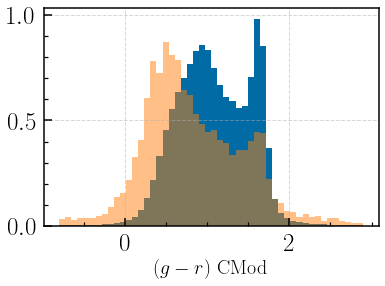

In [178]:
gr_cmod = (-2.5 * np.log10(anom_norm['g_cmodel_flux']/ anom_norm['r_cmodel_flux']))
gr_cmod_weird = (-2.5 * np.log10(anom_weird['g_cmodel_flux']/ anom_weird['r_cmodel_flux']))

_ = plt.hist(gr_cmod, bins=50, density=True, range=(-0.8, 2.9))
_ = plt.hist(gr_cmod_weird, bins=50, alpha=0.5, density=True, range=(-0.8, 2.9))
plt.xlabel(r'$(g-r)\ \rm CMod$', fontsize=20)

<ipython-input-179-10242eecd62d>:1: RuntimeWarning: divide by zero encountered in log10
  ri_cmod = (-2.5 * np.log10(anom_norm['r_cmodel_flux']/ anom_norm['i_cmodel_flux']))
<ipython-input-179-10242eecd62d>:1: RuntimeWarning: invalid value encountered in log10
  ri_cmod = (-2.5 * np.log10(anom_norm['r_cmodel_flux']/ anom_norm['i_cmodel_flux']))
<ipython-input-179-10242eecd62d>:2: RuntimeWarning: divide by zero encountered in log10
  ri_cmod_weird = (-2.5 * np.log10(anom_weird['r_cmodel_flux']/ anom_weird['i_cmodel_flux']))
<ipython-input-179-10242eecd62d>:2: RuntimeWarning: invalid value encountered in log10
  ri_cmod_weird = (-2.5 * np.log10(anom_weird['r_cmodel_flux']/ anom_weird['i_cmodel_flux']))


Text(0.5, 0, '$(r-i)\\ \\rm CMod$')

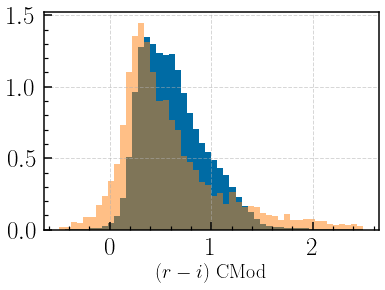

In [179]:
ri_cmod = (-2.5 * np.log10(anom_norm['r_cmodel_flux']/ anom_norm['i_cmodel_flux']))
ri_cmod_weird = (-2.5 * np.log10(anom_weird['r_cmodel_flux']/ anom_weird['i_cmodel_flux']))

_ = plt.hist(ri_cmod, bins=50, density=True, range=(-0.5, 2.5))
_ = plt.hist(ri_cmod_weird, bins=50, alpha=0.5, density=True, range=(-0.5, 2.5))
plt.xlabel(r'$(r-i)\ \rm CMod$', fontsize=20)

#### Aperture color

In [180]:
gr_aper = (-2.5 * np.log10(anom_norm['g_undeblended_convolvedflux_3_20_flux']/ 
                           anom_norm['r_undeblended_convolvedflux_3_20_flux']))
ri_aper = (-2.5 * np.log10(anom_norm['r_undeblended_convolvedflux_3_20_flux'] / 
                           anom_norm['i_undeblended_convolvedflux_3_20_flux']))

gr_aper_weird = (-2.5 * np.log10(anom_weird['g_undeblended_convolvedflux_3_20_flux']/ 
                                 anom_weird['r_undeblended_convolvedflux_3_20_flux']))
ri_aper_weird = (-2.5 * np.log10(anom_weird['r_undeblended_convolvedflux_3_20_flux'] / 
                                 anom_weird['i_undeblended_convolvedflux_3_20_flux']))

<ipython-input-180-9d085ac60551>:1: RuntimeWarning: invalid value encountered in log10
  gr_aper = (-2.5 * np.log10(anom_norm['g_undeblended_convolvedflux_3_20_flux']/
<ipython-input-180-9d085ac60551>:3: RuntimeWarning: invalid value encountered in log10
  ri_aper = (-2.5 * np.log10(anom_norm['r_undeblended_convolvedflux_3_20_flux'] /
<ipython-input-180-9d085ac60551>:6: RuntimeWarning: invalid value encountered in log10
  gr_aper_weird = (-2.5 * np.log10(anom_weird['g_undeblended_convolvedflux_3_20_flux']/
<ipython-input-180-9d085ac60551>:8: RuntimeWarning: invalid value encountered in log10
  ri_aper_weird = (-2.5 * np.log10(anom_weird['r_undeblended_convolvedflux_3_20_flux'] /


Text(0.5, 0, '$(g-r)\\ \\rm Aper$')

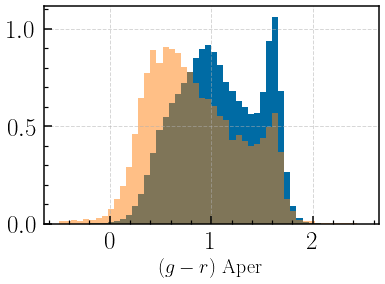

In [181]:
_ = plt.hist(gr_aper, bins=50, density=True, range=(-0.5, 2.5))
_ = plt.hist(gr_aper_weird, bins=50, alpha=0.5, density=True, range=(-0.5, 2.5))
plt.xlabel(r'$(g-r)\ \rm Aper$', fontsize=20)

Text(0.5, 0, '$(r-i)\\ \\rm Aper$')

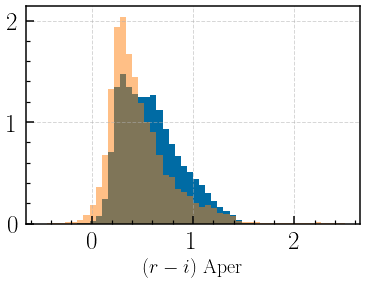

In [182]:
_ = plt.hist(ri_aper, bins=50, density=True, range=(-0.5, 2.5))
_ = plt.hist(ri_aper_weird, bins=50, alpha=0.5, density=True, range=(-0.5, 2.5))
plt.xlabel(r'$(r-i)\ \rm Aper$', fontsize=20)

In [183]:
gr_aper = (-2.5 * np.log10(anom_norm['g_convolvedflux_3_20_flux']/ 
                           anom_norm['r_convolvedflux_3_20_flux']))
ri_aper = (-2.5 * np.log10(anom_norm['r_convolvedflux_3_20_flux'] / 
                           anom_norm['i_convolvedflux_3_20_flux']))

gr_aper_weird = (-2.5 * np.log10(anom_weird['g_convolvedflux_3_20_flux']/ 
                                 anom_weird['r_convolvedflux_3_20_flux']))
ri_aper_weird = (-2.5 * np.log10(anom_weird['r_convolvedflux_3_20_flux'] / 
                                 anom_weird['i_convolvedflux_3_20_flux']))

<ipython-input-183-eb06f97033fd>:1: RuntimeWarning: invalid value encountered in log10
  gr_aper = (-2.5 * np.log10(anom_norm['g_convolvedflux_3_20_flux']/
<ipython-input-183-eb06f97033fd>:3: RuntimeWarning: invalid value encountered in log10
  ri_aper = (-2.5 * np.log10(anom_norm['r_convolvedflux_3_20_flux'] /
<ipython-input-183-eb06f97033fd>:6: RuntimeWarning: invalid value encountered in log10
  gr_aper_weird = (-2.5 * np.log10(anom_weird['g_convolvedflux_3_20_flux']/
<ipython-input-183-eb06f97033fd>:8: RuntimeWarning: invalid value encountered in log10
  ri_aper_weird = (-2.5 * np.log10(anom_weird['r_convolvedflux_3_20_flux'] /


Text(0.5, 0, '$(g-r)\\ \\rm Aper$')

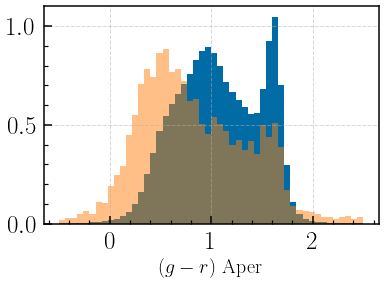

In [184]:
_ = plt.hist(gr_aper, bins=50, density=True, range=(-0.5, 2.5))
_ = plt.hist(gr_aper_weird, bins=50, alpha=0.5, density=True, range=(-0.5, 2.5))
plt.xlabel(r'$(g-r)\ \rm Aper$', fontsize=20)

Text(0.5, 0, '$(r-i)\\ \\rm Aper$')

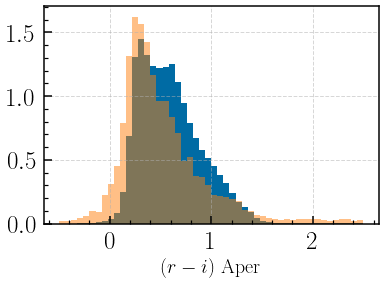

In [185]:
_ = plt.hist(ri_aper, bins=50, density=True, range=(-0.5, 2.5))
_ = plt.hist(ri_aper_weird, bins=50, alpha=0.5, density=True, range=(-0.5, 2.5))
plt.xlabel(r'$(r-i)\ \rm Aper$', fontsize=20)

#### Ratio between aperture flux and CModel flux

<ipython-input-186-545c63fb5731>:1: RuntimeWarning: invalid value encountered in log10
  aper_ratio = np.log10(anom_norm['i_undeblended_convolvedflux_3_20_flux'] / anom_norm['i_cmodel_flux'])


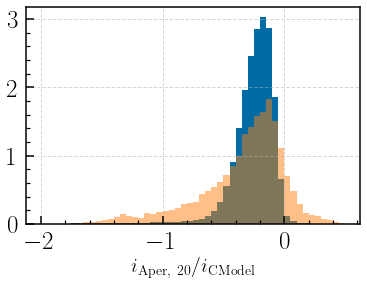

In [186]:
aper_ratio = np.log10(anom_norm['i_undeblended_convolvedflux_3_20_flux'] / anom_norm['i_cmodel_flux'])
aper_ratio_w = np.log10(anom_weird['i_undeblended_convolvedflux_3_20_flux'] / anom_weird['i_cmodel_flux'])

_ = plt.hist(aper_ratio, bins=50, density=True, range=(-2, 0.5))
_ = plt.hist(aper_ratio_w, bins=50, alpha=0.5, density=True, range=(-2, 0.5))
_ = plt.xlabel(r'$i_{\rm Aper,\ 20}/i_{\rm CModel}$', fontsize=20)

<ipython-input-187-19683713355a>:1: RuntimeWarning: invalid value encountered in log10
  aper_ratio = np.log10(anom_norm['i_convolvedflux_3_20_flux'] / anom_norm['i_cmodel_flux'])
<ipython-input-187-19683713355a>:2: RuntimeWarning: invalid value encountered in log10
  aper_ratio_w = np.log10(anom_weird['i_convolvedflux_3_20_flux'] / anom_weird['i_cmodel_flux'])


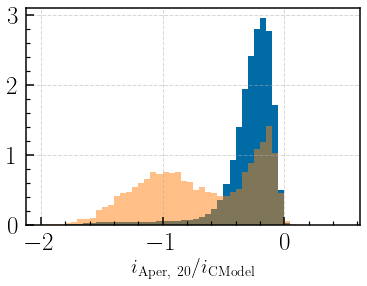

In [187]:
aper_ratio = np.log10(anom_norm['i_convolvedflux_3_20_flux'] / anom_norm['i_cmodel_flux'])
aper_ratio_w = np.log10(anom_weird['i_convolvedflux_3_20_flux'] / anom_weird['i_cmodel_flux'])

_ = plt.hist(aper_ratio, bins=50, density=True, range=(-2, 0.5))
_ = plt.hist(aper_ratio_w, bins=50, alpha=0.5, density=True, range=(-2, 0.5))
_ = plt.xlabel(r'$i_{\rm Aper,\ 20}/i_{\rm CModel}$', fontsize=20)

<ipython-input-188-3656166af6d5>:1: RuntimeWarning: divide by zero encountered in true_divide
  aper_ratio = np.log10(anom_norm['r_convolvedflux_3_20_flux'] / anom_norm['r_cmodel_flux'])
<ipython-input-188-3656166af6d5>:1: RuntimeWarning: invalid value encountered in log10
  aper_ratio = np.log10(anom_norm['r_convolvedflux_3_20_flux'] / anom_norm['r_cmodel_flux'])
<ipython-input-188-3656166af6d5>:2: RuntimeWarning: divide by zero encountered in true_divide
  aper_ratio_w = np.log10(anom_weird['r_convolvedflux_3_20_flux'] / anom_weird['r_cmodel_flux'])
<ipython-input-188-3656166af6d5>:2: RuntimeWarning: invalid value encountered in log10
  aper_ratio_w = np.log10(anom_weird['r_convolvedflux_3_20_flux'] / anom_weird['r_cmodel_flux'])


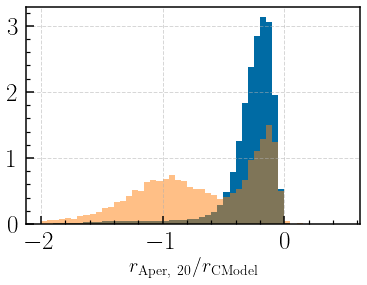

In [188]:
aper_ratio = np.log10(anom_norm['r_convolvedflux_3_20_flux'] / anom_norm['r_cmodel_flux'])
aper_ratio_w = np.log10(anom_weird['r_convolvedflux_3_20_flux'] / anom_weird['r_cmodel_flux'])

_ = plt.hist(aper_ratio, bins=50, density=True, range=(-2, 0.5))
_ = plt.hist(aper_ratio_w, bins=50, alpha=0.5, density=True, range=(-2, 0.5))
_ = plt.xlabel(r'$r_{\rm Aper,\ 20}/r_{\rm CModel}$', fontsize=20)

#### Color difference between CModel and Aperture

In [189]:
gr_aper = (-2.5 * np.log10(anom_norm['g_undeblended_convolvedflux_3_20_flux']/ 
                           anom_norm['r_undeblended_convolvedflux_3_20_flux']))
ri_aper = (-2.5 * np.log10(anom_norm['r_undeblended_convolvedflux_3_20_flux'] / 
                           anom_norm['i_undeblended_convolvedflux_3_20_flux']))
rz_aper = (-2.5 * np.log10(anom_norm['r_undeblended_convolvedflux_3_20_flux'] / 
                           anom_norm['z_undeblended_convolvedflux_3_20_flux']))

gr_aper_weird = (-2.5 * np.log10(anom_weird['g_undeblended_convolvedflux_3_20_flux']/ 
                                 anom_weird['r_undeblended_convolvedflux_3_20_flux']))
ri_aper_weird = (-2.5 * np.log10(anom_weird['r_undeblended_convolvedflux_3_20_flux'] / 
                                 anom_weird['i_undeblended_convolvedflux_3_20_flux']))
rz_aper_weird = (-2.5 * np.log10(anom_weird['r_undeblended_convolvedflux_3_20_flux'] / 
                                 anom_weird['z_undeblended_convolvedflux_3_20_flux']))

<ipython-input-189-d7deb71397da>:1: RuntimeWarning: invalid value encountered in log10
  gr_aper = (-2.5 * np.log10(anom_norm['g_undeblended_convolvedflux_3_20_flux']/
<ipython-input-189-d7deb71397da>:3: RuntimeWarning: invalid value encountered in log10
  ri_aper = (-2.5 * np.log10(anom_norm['r_undeblended_convolvedflux_3_20_flux'] /
<ipython-input-189-d7deb71397da>:5: RuntimeWarning: invalid value encountered in log10
  rz_aper = (-2.5 * np.log10(anom_norm['r_undeblended_convolvedflux_3_20_flux'] /
<ipython-input-189-d7deb71397da>:8: RuntimeWarning: invalid value encountered in log10
  gr_aper_weird = (-2.5 * np.log10(anom_weird['g_undeblended_convolvedflux_3_20_flux']/
<ipython-input-189-d7deb71397da>:10: RuntimeWarning: invalid value encountered in log10
  ri_aper_weird = (-2.5 * np.log10(anom_weird['r_undeblended_convolvedflux_3_20_flux'] /
<ipython-input-189-d7deb71397da>:12: RuntimeWarning: invalid value encountered in log10
  rz_aper_weird = (-2.5 * np.log10(anom_weird['r_undeb

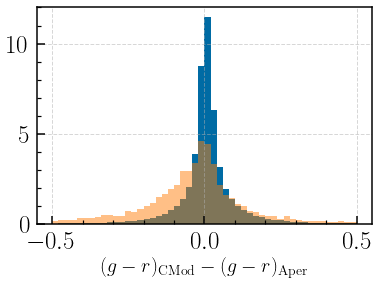

In [190]:
_ = plt.hist(gr_cmod - gr_aper, bins=50, density=True, range=(-0.5, 0.5))
_ = plt.hist(gr_cmod_weird - gr_aper_weird, bins=50, alpha=0.5, density=True, range=(-0.5, 0.5))
_ = plt.xlabel(r'$(g-r)_{\rm CMod} - (g-r)_{\rm Aper}$', fontsize=20)

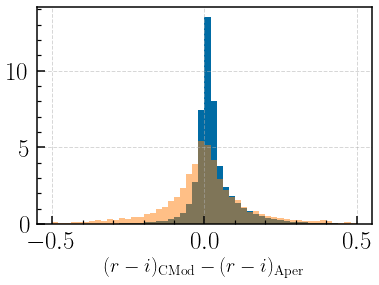

In [191]:
_ = plt.hist(ri_cmod - ri_aper, bins=50, density=True, range=(-0.5, 0.5))
_ = plt.hist(ri_cmod_weird - ri_aper_weird, bins=50, alpha=0.5, density=True, range=(-0.5, 0.5))
_ = plt.xlabel(r'$(r-i)_{\rm CMod} - (r-i)_{\rm Aper}$', fontsize=20)

#### Size and shape

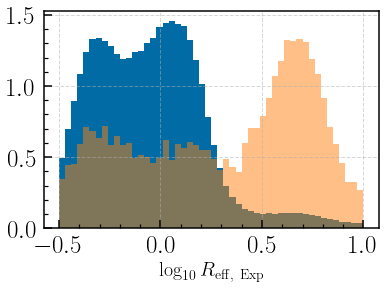

In [194]:
logr = np.log10(anom_norm['i_cmodel_exp_ellipse_r'])
logr_weird = np.log10(anom_weird['i_cmodel_exp_ellipse_r'])

_ = plt.hist(logr, bins=50, density=True, range=(-0.5, 1.0))
_ = plt.hist(logr_weird, bins=50, alpha=0.5, density=True, range=(-0.5, 1.0))
_ = plt.xlabel(r'$\log_{10} R_{\rm eff,\ Exp}$', fontsize=20)

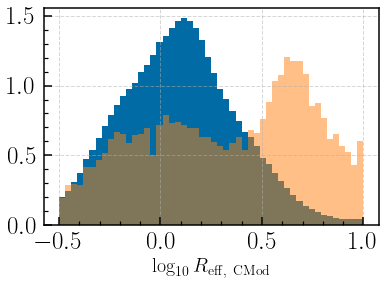

In [195]:
logr = np.log10(anom_norm['i_cmodel_ellipse_r'])
logr_weird = np.log10(anom_weird['i_cmodel_ellipse_r'])

_ = plt.hist(logr, bins=50, density=True, range=(-0.5, 1.0))
_ = plt.hist(logr_weird, bins=50, alpha=0.5, density=True, range=(-0.5, 1.0))
_ = plt.xlabel(r'$\log_{10} R_{\rm eff,\ CMod}$', fontsize=20)

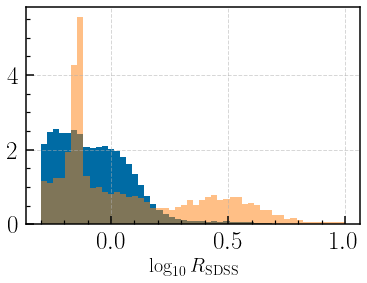

In [196]:
logr = np.log10(anom_norm['i_sdss_shape_r'])
logr_weird = np.log10(anom_weird['i_sdss_shape_r'])

_ = plt.hist(logr, bins=50, density=True, range=(-0.3, 1.0))
_ = plt.hist(logr_weird, bins=50, alpha=0.5, density=True, range=(-0.3, 1.0))
_ = plt.xlabel(r'$\log_{10} R_{\rm SDSS}$', fontsize=20)

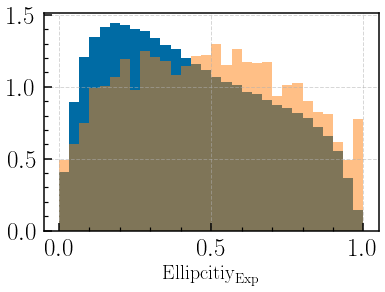

In [202]:
ell = anom_norm['i_cmodel_exp_ellipse_e']
ell_weird = anom_weird['i_cmodel_exp_ellipse_e']

_ = plt.hist(ell, bins=30, density=True, range=(0.0, 1.0))
_ = plt.hist(ell_weird, bins=30, alpha=0.5, density=True, range=(0.0, 1.0))
_ = plt.xlabel(r'${\rm Ellipcitiy}_{\rm Exp}$', fontsize=20)

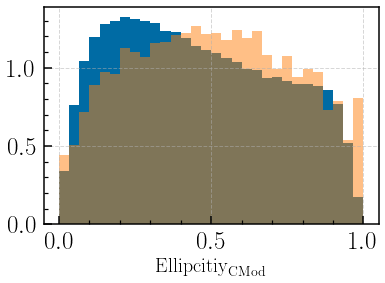

In [198]:
ell = anom_norm['i_cmodel_ellipse_e']
ell_weird = anom_weird['i_cmodel_ellipse_e']

_ = plt.hist(ell, bins=30, density=True, range=(0.0, 1.0))
_ = plt.hist(ell_weird, bins=30, alpha=0.5, density=True, range=(0.0, 1.0))
_ = plt.xlabel(r'${\rm Ellipcitiy}_{\rm CMod}$', fontsize=20)

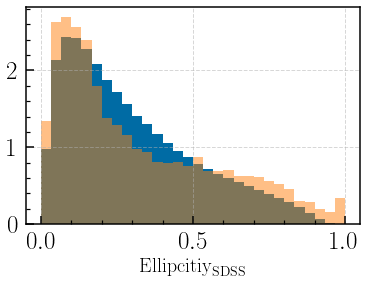

In [199]:
ell = anom_norm['i_sdss_shape_e']
ell_weird = anom_weird['i_sdss_shape_e']

_ = plt.hist(ell, bins=30, density=True, range=(0.0, 1.0))
_ = plt.hist(ell_weird, bins=30, alpha=0.5, density=True, range=(0.0, 1.0))
_ = plt.xlabel(r'${\rm Ellipcitiy}_{\rm SDSS}$', fontsize=20)

In [176]:
anom_bsm_gal.write('/Users/song/Downloads/anomaly/anomaly_catalog_hsc_gal.fits', overwrite=True)
anom_weird.write('/Users/song/Downloads/anomaly/anomaly_catalog_hsc_weird.fits', overwrite=True)

In [200]:
anom_norm.write('/Users/song/Downloads/anomaly/anomaly_catalog_hsc_normal.fits', overwrite=True)